In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.models import load_model
from keras.applications import DenseNet121
from keras.utils import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,GlobalAveragePooling2D, Dense

specifying the number of channels in the input images, the number of epochs for training, batch size, image dimensions, and other variables related to data and classes.

In [ ]:
channels =3
EPOCHS = 10
counter = 15
BATCH_SIZE=32
img_height, img_width=150,150
nb_validation_samples = 3050
nb_train_samples = 30076

y = ['benign train RESIZE', 'train malignant 534']
class_names = np.unique(y)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_names, y=y)
class_weights_dict = dict(enumerate(class_weights))

path_train= '/content/drive/MyDrive/data/train'
path_validation="/content/drive/MyDrive/data/validation/"
path_test = '/content/drive/MyDrive/data/all/test'
path_categories_validation=["benign 3000 RESIZE/","validation malignant 50/"]


df_3rd_place = pd.read_csv('/content/drive/MyDrive/3rd_place.csv')
df_our_prediction_1=pd.read_csv('/content/drive/MyDrive/predictions.csv')
df_train=pd.read_csv('/content/drive/MyDrive/MetaData/train.csv')

Building an architecture for loading a trained model on the condition that only weights are saved (to lighten the weight of the file)

In [ ]:
# base_model = DenseNet121(weights='imagenet', include_top=False)
# base_model.trainable = False

# inputs = Input(shape=(150,150,3))
# x1 = base_model(inputs, training=False)
# x2 = GlobalAveragePooling2D()(x1)
# x3 = Dense(10,activation="relu")(x2)
# x4 = Dense(10,activation="relu")(x3)
# outputs = Dense(2, activation='softmax')(x4)
# model = tf.keras.Model(inputs, outputs, name='load_model')

# print(model.summary())

Model: "load_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                        

In [ ]:
# model_path = '/content/drive/MyDrive/modelsCheckpoints/model_1.h5'
# model.load_weights(model_path)
# print(model.summary())

Model: "load_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                        

In [ ]:
model = load_model("/content/drive/MyDrive/modelsCheckpoints/model_3.h5") #Loading a complete model

printing the weights and biases from the last layer of the model that can provide insights on the learned representations of the model.

In [ ]:
last_layer = model.layers[-1]
weights = last_layer.get_weights()[0]
biases = last_layer.get_weights()[1]

print("Last layer weights:")
print(weights)
print("Last layer biases:")
print(biases)

Last layer weights:
[[-0.09101431  0.07999042]
 [-0.10344913  0.196905  ]
 [ 0.05397443  0.5175301 ]
 [-0.48127353  0.34477302]
 [ 0.5548655  -0.08558794]
 [-0.07623629 -0.59770733]
 [-0.23368394 -0.7236882 ]
 [-0.34956047  0.63572997]
 [ 0.50135326  0.12742285]
 [ 0.392357    0.09179808]]
Last layer biases:
[ 0.01680295 -0.01680295]


**Prediction for validation**

preparing the image data generator for validation data. the generator rescales the pixel values of the images.

In [ ]:
validation_image_generator = ImageDataGenerator(rescale=1./255)

val_data_gen = validation_image_generator.flow_from_directory(
    directory= path_validation,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    classes=['benign 3000 RESIZE', 'validation malignant 50'],
    class_mode='categorical'
)

Found 3050 images belonging to 2 classes.


In [ ]:
Y_pred = model.predict(val_data_gen, val_data_gen.samples / BATCH_SIZE)
val_preds = np.argmax(Y_pred, axis=1)
val_trues =val_data_gen.classes

96/96 [==============================] - 358s 3s/step


calculating accuracy, AUC, and confusion matrix for the validation data using the predicted labels and true labels.

[0 0 0 ... 1 1 1] [0 0 0 ... 0 0 0]
Accuracy validation Score: 0.9770491803278688
AUC validation Score: 0.49666666666666665
AUC2 validation Score: 0.49666666666666665


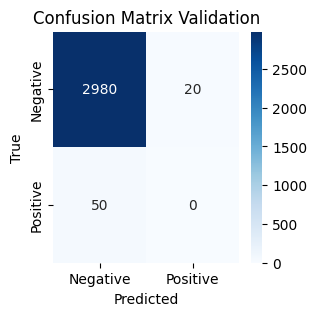

In [ ]:
print(val_trues, val_preds)
accuracy_validation = accuracy_score(val_trues, val_preds)
auc_validation = roc_auc_score(val_trues, val_preds)
auc_validation2 = roc_auc_score(val_preds, val_trues)
conf_matrix_validation = confusion_matrix(val_trues, val_preds)
print("Accuracy validation Score:", accuracy_validation)
print("AUC validation Score:", auc_validation)
print("AUC2 validation Score:", auc_validation)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix_validation, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Validation")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()

In [ ]:
#Predication without generator

predictions = []
for category in path_categories_validation:
  path = path_validation +category
  for i in os.listdir(path):
      img = load_img(path+i, grayscale=False,target_size=(150, 150))
      print(i)
      img = img_to_array(img)
      img = img.reshape(1, 150, 150, channels).astype('float32')
      img = img / 255.0
      pred=model.predict(img)
      predictions += [[i,pred,np.argmax(pred)]]
      print("predictions:{} category:{}".format(pred,np.argmax(pred)))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 113ms/step
predictions:[[0.996197   0.00380309]] category:0
ISIC_5355196.jpg
1/1 [==============================] - 0s 115ms/step
predictions:[[0.990051   0.00994899]] category:0
ISIC_7870834.jpg
1/1 [==============================] - 0s 114ms/step
predictions:[[9.994808e-01 5.192232e-04]] category:0
ISIC_5888672.jpg
1/1 [==============================] - 0s 102ms/step
predictions:[[0.9873886  0.01261138]] category:0
ISIC_8409850.jpg
1/1 [==============================] - 0s 135ms/step
predictions:[[9.992987e-01 7.012689e-04]] category:0
ISIC_6073559.jpg
1/1 [==============================] - 0s 122ms/step
predictions:[[0.9965821  0.00341788]] category:0
ISIC_9805957.jpg
1/1 [==============================] - 0s 115ms/step
predictions:[[0.9972645  0.00273556]] category:0
ISIC_3063563.jpg
1/1 [==============================] - 0s 118ms/step
predictions:[[0.9968526  0.00314744]] category:0
ISIC_8

In [ ]:
#Collecting the predicted data according to the model and continuing manual prediction

df_predictions = pd.DataFrame(predictions, columns=['image_name', 'prediction', 'prediction_label'])
df_predictions['prediction'] = df_predictions['prediction'].apply(lambda x: x[0])
df_predictions['image_name'] = df_predictions['image_name'].apply(lambda x: x[:-4])  # Remove file extension from image_name
df_predictions

,image_name,prediction,prediction_label
0,ISIC_5927617,"[0.99952435, 0.00047562167]",0
1,ISIC_2686026,"[0.9967098, 0.0032901478]",0
2,ISIC_6687327,"[0.9989034, 0.0010966021]",0
3,ISIC_5121178,"[0.99377924, 0.0062207202]",0
4,ISIC_6597839,"[0.9979145, 0.0020855453]",0
...,...,...,...
3045,ISIC_8732757,"[0.85977066, 0.14022928]",0
3046,ISIC_8985109,"[0.49614176, 0.50385827]",1
3047,ISIC_9000234,"[0.9834879, 0.016512038]",0
3048,ISIC_9038318,"[0.7056283, 0.29437166]",0


In [ ]:
merged_df = pd.merge(df_train[['image_name','target']], df_predictions[['image_name','prediction_label']], left_on='image_name', right_on='image_name')
print(merged_df)
accuracy_validation = accuracy_score(merged_df['target'], merged_df['prediction_label'])
auc_validation = roc_auc_score(merged_df['target'],  merged_df['prediction_label'])
conf_matrix_validation = confusion_matrix(merged_df['target'], merged_df['prediction_label'])

        image_name  target  prediction_label
0     ISIC_0089738       0                 0
1     ISIC_0090279       0                 0
2     ISIC_0099474       0                 0
3     ISIC_0106091       0                 0
4     ISIC_0112097       0                 0
...            ...     ...               ...
3045  ISIC_9981925       0                 0
3046  ISIC_9985224       0                 0
3047  ISIC_9986333       0                 0
3048  ISIC_9987808       0                 0
3049  ISIC_9988559       0                 0

[3050 rows x 3 columns]


Accuracy validation Score: 0.9855737704918033
AUC validation Score: 0.6288333333333334


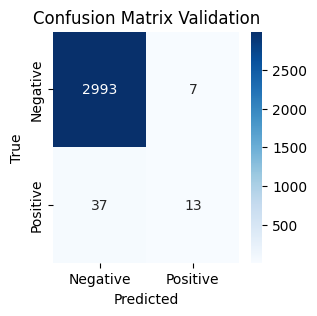

In [ ]:
print("Accuracy validation Score:", accuracy_validation)
print("AUC validation Score:", auc_validation)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix_validation, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Validation")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()

**Additional training for the loaded model**

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/modelsCheckpoints/model_2.h5'

train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=10,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           shear_range=0.1,
                                           zoom_range=0.1,
                                           horizontal_flip=True,
                                           vertical_flip=False)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(directory=path_train,
                                                           target_size=(img_width, img_height),
                                                           batch_size=BATCH_SIZE,
                                                           classes=['benign train RESIZE', 'train malignant 534'],
                                                           class_mode='categorical')
val_data_gen = validation_image_generator.flow_from_directory(directory=path_validation,
                                                              target_size=(img_width, img_height),
                                                              batch_size=BATCH_SIZE,
                                                              classes=['benign 3000 RESIZE', 'validation malignant 50'],
                                                              class_mode='categorical')

model.compile(optimizer=Adam(0.0001), loss="categorical_crossentropy", metrics=['accuracy', AUC()])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               verbose=1,
                                                               save_best_only=True,
                                                               save_weights_only=True,
                                                               monitor='val_auc',
                                                               mode='max',
                                                               save_freq='epoch')

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(nb_train_samples / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(nb_validation_samples / float(BATCH_SIZE))),
    callbacks=[model_checkpoint_callback],
    class_weight=class_weights_dict
)

Found 30076 images belonging to 2 classes.
Found 3050 images belonging to 2 classes.
Epoch 1/10
483/940 [==============>...............] - ETA: 23:21 - loss: 0.0493 - accuracy: 0.9832 - auc_2: 0.9982

KeyboardInterrupt: ignored

**test prediction**

The prediction for the test is more complex than and we do not have labeling of the test classes,
When we manage to load the saved model correctly, we will make a prediction for the test according to the labeling results we found on the web (https://github.com/Masdevallia/3rd-place-kaggle-siim-isic-melanoma-classification)

Creating a prediction file for submission in the competition

In [ ]:
output_file_path = '/content/drive/MyDrive/predictions_2.csv'

data = list(zip(image_names, predictions))
with open(output_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_name', 'prediction'])  # Write the header
    writer.writerows(data)
print(f"CSV file created successfully at: {output_file_path}")

CSV file created successfully at: /content/drive/MyDrive/predictions.csv
